In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.signal import lfilter
from scipy import signal
import scipy
import math
from iir_biquad import iir_biquad as iir_biquad_patrick
from iir_biquad import test as test_patrick
from IIRSim import *
from FrequencyResponse import *


In [2]:
notch_freq = 395
b, a = signal.iirnotch(notch_freq, 2, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)
print(pmag, pangle)

0.8081683126691569 0.8061434976591624


<Figure size 640x480 with 0 Axes>

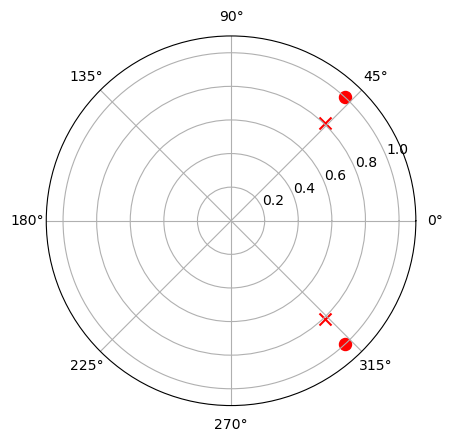

In [3]:
plot_filter_polezero(zmag, zangle, pmag, pangle)

In [ ]:
#notch_freq = 395
for notch_freq in range(50,1500,5):
    plt.clf()
    b, a = signal.iirnotch(notch_freq, 2, 3000)
    pole = signal.tf2zpk(b,a)[1][0]
    zero = signal.tf2zpk(b,a)[0][0]
    pmag=np.abs(pole)
    pangle=np.angle(pole)
    zmag=np.abs(zero)
    zangle=np.angle(zero)
    print(pmag, pangle)
    samples = 1000
    sample_freqs =  np.linspace(0,0.99,samples)
    freq_response = eval_biquad_filter_DFT(zmag, zangle, pmag, pangle, sample_freqs)
    freq_response_quantized = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*1000, amplitude=False, phase=0)
    
    freq_response_quantized_0p5 = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*1000, amplitude=False, phase=0, in_amplitude=0.5)
    
    freq_response_quantized_0p1 = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*1000, amplitude=False, phase=0, in_amplitude=0.1)
    
    freq_response_quantized_0p01 = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*1000, amplitude=False, phase=0, in_amplitude=0.01)
    
    freq_response_quantized_0p001 = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*1000, amplitude=False, phase=0, in_amplitude=0.001)
    
    # freq_response_quantized_smalln = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*100, amplitude=False, phase=0)
    
    cmap = plt.cm.inferno#plasma
    norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
    #=cmap(norm(df.c.values))
    
    sample_freqs_scaled = sample_freqs * 1500
    plt.semilogy(sample_freqs_scaled,freq_response, label="ideal", color = cmap(norm(0)))
    plt.semilogy(sample_freqs_scaled,freq_response_quantized, label="quantized 100.0% amplitude", color = cmap(norm(1)))
    # plt.semilogy(sample_freqs_scaled,freq_response_quantized_smalln, label="quantized small n")
    plt.semilogy(sample_freqs_scaled,freq_response_quantized_0p5, label="quantized 50.0% amplitude", color = cmap(norm(2)))
    plt.semilogy(sample_freqs_scaled,freq_response_quantized_0p1, label="quantized 10.0% amplitude", color = cmap(norm(3)))
    plt.semilogy(sample_freqs_scaled,freq_response_quantized_0p01, label="quantized 01.0% amplitude", color = cmap(norm(4)))
    plt.semilogy(sample_freqs_scaled,freq_response_quantized_0p001, label="quantized 00.1% amplitude", color = cmap(norm(5)))
    plt.legend()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Gain")
    plt.ylim(0.0001,1.4)
    plt.title("IIR with notch at %s MHz"%(notch_freq))
    # plt.xlim(700,800)
    plt.savefig("freqResponseNotch%sMHz.png"%(notch_freq))
    plt.show()

In [ ]:
#notch_freq = 395
for notch_freq in range(50,1500,5):
    plt.clf()
    b, a = signal.iirnotch(notch_freq, 2, 3000)
    # First generate the coefficients for the FPGA Biquad
    pole = signal.tf2zpk(b,a)[1][0]
    zero = signal.tf2zpk(b,a)[0][0]
    mag=np.abs(pole)
    angle=np.angle(pole)
    coeffs = iir_biquad_coeffs(mag, angle)
    coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
    coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
    b_fixed_point_signed = np.zeros(len(b))
    # For transfer function numerator
    for i in range(len(b)):
        b_fixed_point_signed[i] = np.array(np.floor(b[i] * (2**14)),dtype=np.int64)
    a_fixed_point_signed = np.zeros(len(a))
    # For transfer function denominator, after look-ahead
    for i in range(len(a)):
        a_fixed_point_signed[i] = np.array(np.floor(a[i] * (2**14)),dtype=np.int64)
    # For clustered look-ahead
    for i in range(len(coeffs_fixed_point)):
        # Coefficients are in Q4.14, where the sign bit IS counted
        coeffs_fixed_point_signed[i] = np.array(np.floor(coeffs[i] * (2**14)),dtype=np.int64)
        # coeffs_fixed_point[i] = convert_to_fixed_point(np.array(coeffs[i]), 4, 14)
    samp_per_clock=8
    f_fir = coeffs_fixed_point_signed[0:samp_per_clock-2]
    g_fir = coeffs_fixed_point_signed[samp_per_clock-2:2*samp_per_clock-3]
    D_FF = coeffs_fixed_point_signed[2*samp_per_clock-3 + 0]
    D_FG = coeffs_fixed_point_signed[2*samp_per_clock-3 + 1]
    E_GF = coeffs_fixed_point_signed[2*samp_per_clock-3 + 2]
    E_GG = coeffs_fixed_point_signed[2*samp_per_clock-3 + 3]
    C = coeffs_fixed_point_signed[2*samp_per_clock-3 + 4:2*samp_per_clock-3 + 4 + 4]

    
    with open("freq_files/coeff_file_%sMHz.dat"%(notch_freq),"w") as coeff_file:
        coeff_file.write("%d\n"%(int(b_fixed_point_signed[1])))# B
        coeff_file.write("%d\n"%(int(b_fixed_point_signed[0])))# A

        coeff_file.write("%d\n"%(int(C[2])))# C2
        coeff_file.write("%d\n"%(int(C[3])))# C3
        coeff_file.write("%d\n"%(int(C[1])))# C1
        coeff_file.write("%d\n"%(int(C[0])))# C0

        coeff_file.write("%d\n"%(int(a_fixed_point_signed[2])))# a2'
        coeff_file.write("%d\n"%(int(a_fixed_point_signed[1])))# a1'        

        coeff_file.write("%d\n"%(int(D_FF)))# D_FF
        coeff_file.write("%d\n"%(int(f_fir[5])))# X6
        coeff_file.write("%d\n"%(int(f_fir[4])))# X5
        coeff_file.write("%d\n"%(int(f_fir[3])))# X4
        coeff_file.write("%d\n"%(int(f_fir[2])))# X3
        coeff_file.write("%d\n"%(int(f_fir[1])))# X2
        coeff_file.write("%d\n"%(int(f_fir[0])))# X1

        coeff_file.write("%d\n"%(int(E_GG)))# E_GG
        coeff_file.write("%d\n"%(int(g_fir[6])))# X7
        coeff_file.write("%d\n"%(int(g_fir[5])))# X6
        coeff_file.write("%d\n"%(int(g_fir[4])))# X5
        coeff_file.write("%d\n"%(int(g_fir[3])))# X4
        coeff_file.write("%d\n"%(int(g_fir[2])))# X3
        coeff_file.write("%d\n"%(int(g_fir[1])))# X2
        coeff_file.write("%d\n"%(int(g_fir[0])))# X1
        
        coeff_file.write("%d\n"%(int(D_FG)))# D_FG
        
        coeff_file.write("%d\n"%(int(E_GF)))# E_GF

        for a_i in a_fixed_point_signed:
            coeff_file.write("%d\n"%(int(a_i)))
        for b_i in b_fixed_point_signed:
            coeff_file.write("%d\n"%(int(b_i)))

In [4]:
verilog_frequency_responses = {}
for notch_freq in range(50,1500,25):
    verilog_frequency_responses[notch_freq] = {}
    for input_freq in range(5,1491,25):
        with open("freq_files/output_%s_MHz_notch_%s_MHz.txt"%(input_freq, notch_freq), "r") as in_file:
            data = []
            for line in in_file:
                data.append(convert_from_fixed_point(int(int(line)), 12, 0))
            verilog_frequency_responses[notch_freq][input_freq] = np.array(data,dtype=np.int64)
            

In [5]:
verilog_frequency_responses_expanded = {}
for notch_freq in range(350,1500,250):
    verilog_frequency_responses_expanded[notch_freq] = {}
    for input_freq in range(5,1491,25):
        with open("freq_files/output_expanded_%s_MHz_notch_%s_MHz.txt"%(input_freq, notch_freq), "r") as in_file:
            data = []
            for line in in_file:
                data.append(convert_from_fixed_point(int(int(line)), 21, 27))
            verilog_frequency_responses_expanded[notch_freq][input_freq] = np.array(data,dtype=np.int64)
            

In [20]:
input_frequencies = {}
for in_freq in range(5,1491,5):
    data = []
    with open("freq_files/input_%s_MHz.dat"%(in_freq), "r") as in_file:
        for line in in_file:
            data.append(convert_from_fixed_point(int(line), 12, 0))
    input_frequencies[in_freq] = np.concatenate((np.zeros(4*8,dtype=np.int64),np.array(data,dtype=np.int64)))

In [21]:
input_frequencies[750]

array([ 0,  0,  0, ..., -1,  0,  0], dtype=int64)

[ 13822. -20544.  13822.]


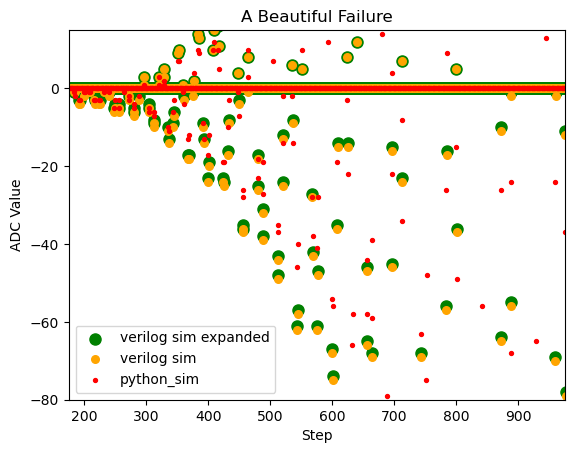

In [51]:
notch_freq = 350#750
test_freq = 205#750
b, a = signal.iirnotch(notch_freq, 2, 3000)
# First generate the coefficients for the FPGA Biquad
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
mag=np.abs(pole)
angle=np.angle(pole)
coeffs = iir_biquad_coeffs(mag, angle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.array(np.floor(b[i] * (2**14)),dtype=np.int64)
# a_fixed_point_signed = np.zeros(len(a))
# # For transfer function denominator, after look-ahead
# for i in range(len(a)):
#     a_fixed_point_signed[i] = np.array(np.floor(a[i] * (2**14)),dtype=np.int64)
# # For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.array(np.floor(coeffs[i] * (2**14)),dtype=np.int64)
    # coeffs_fixed_point[i] = convert_to_fixed_point(np.array(coeffs[i]), 4, 14)

values_with_FIR = np.right_shift(np.array(np.floor(signal.lfilter(b_fixed_point_signed, [1], input_frequencies[test_freq])),dtype=np.int64),14)
print(b_fixed_point_signed)
# for i in range(100):
    # print("x0: %s"%values_with_FIR[i*8])
    # print("x1: %s"%values_with_FIR[i*8+1])
values_filtered = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
                                             decimate=True, a1=0, a2=0,debug=0)   


# plt.scatter(range(len(input_frequencies[test_freq])), input_frequencies[test_freq], color='blue', label='input', s=5)
py_shift=144
plt.scatter(range(8,len(verilog_frequency_responses_expanded[notch_freq][test_freq])+8), verilog_frequency_responses_expanded[notch_freq][test_freq], 
            color='green', label='verilog sim expanded', s=64)
plt.scatter(range(len(verilog_frequency_responses[notch_freq][test_freq])), verilog_frequency_responses[notch_freq][test_freq], 
            color='orange', label='verilog sim', s=30)
plt.scatter(range(py_shift,len(input_frequencies[test_freq])+py_shift), values_filtered, color='red', label='python_sim', s=8)
plt.legend()
plt.title("A Beautiful Failure")
plt.xlabel("Step")
plt.ylabel("ADC Value")
plt.xlim(175,975)
plt.ylim(-80,15)
plt.savefig("debug.png", dpi=250)
plt.show()

# Analysis of Verilog Sim

In [ ]:
#notch_freq = 395
for notch_freq in range(350,1500,250):
    for input_freq in range(5,1491,25):
    # JUST FREQ ANALYSIS INSTEAD
    freq_response_quantized = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*1000, amplitude=False, phase=0)
    
    freq_response_quantized_0p5 = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*1000, amplitude=False, phase=0, in_amplitude=0.5)
    
    freq_response_quantized_0p1 = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*1000, amplitude=False, phase=0, in_amplitude=0.1)
    
    freq_response_quantized_0p01 = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*1000, amplitude=False, phase=0, in_amplitude=0.01)
    
    freq_response_quantized_0p001 = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*1000, amplitude=False, phase=0, in_amplitude=0.001)
    
    # freq_response_quantized_smalln = eval_biquad_quantized_DFT(b, a, sample_freqs, internal_samples=8*100, amplitude=False, phase=0)
    
    cmap = plt.cm.inferno#plasma
    norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
    #=cmap(norm(df.c.values))
    
    sample_freqs_scaled = sample_freqs * 1500
    plt.semilogy(sample_freqs_scaled,freq_response, label="ideal", color = cmap(norm(0)))
    plt.semilogy(sample_freqs_scaled,freq_response_quantized, label="quantized 100.0% amplitude", color = cmap(norm(1)))
    # plt.semilogy(sample_freqs_scaled,freq_response_quantized_smalln, label="quantized small n")
    plt.semilogy(sample_freqs_scaled,freq_response_quantized_0p5, label="quantized 50.0% amplitude", color = cmap(norm(2)))
    plt.semilogy(sample_freqs_scaled,freq_response_quantized_0p1, label="quantized 10.0% amplitude", color = cmap(norm(3)))
    plt.semilogy(sample_freqs_scaled,freq_response_quantized_0p01, label="quantized 01.0% amplitude", color = cmap(norm(4)))
    plt.semilogy(sample_freqs_scaled,freq_response_quantized_0p001, label="quantized 00.1% amplitude", color = cmap(norm(5)))
    plt.legend()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Gain")
    plt.ylim(0.0001,1.4)
    plt.title("IIR with notch at %s MHz"%(notch_freq))
    # plt.xlim(700,800)
    plt.savefig("freqResponseNotch%sMHz.png"%(notch_freq))
    plt.show()